Loading data...
Dataset shape: (4311, 17)

Selected features: ['duration', 'contact', 'housing', 'loan', 'previous', 'pdays']
Target variable: y

Preprocessing data...
Feature info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4311 entries, 0 to 4310
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   duration  4311 non-null   int64 
 1   contact   4311 non-null   object
 2   housing   4311 non-null   object
 3   loan      4311 non-null   object
 4   previous  4311 non-null   int64 
 5   pdays     4311 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 202.2+ KB
None

Target distribution:
y
no     3813
yes     498
Name: count, dtype: int64

Categorical features: ['contact', 'housing', 'loan']
Numerical features: ['duration', 'previous', 'pdays']
Encoded contact: ['cellular' 'telephone' 'unknown']
Encoded housing: ['no' 'yes']
Encoded loan: ['no' 'yes']
Target encoded: ['no' 'yes']

Splitting data...
Training set

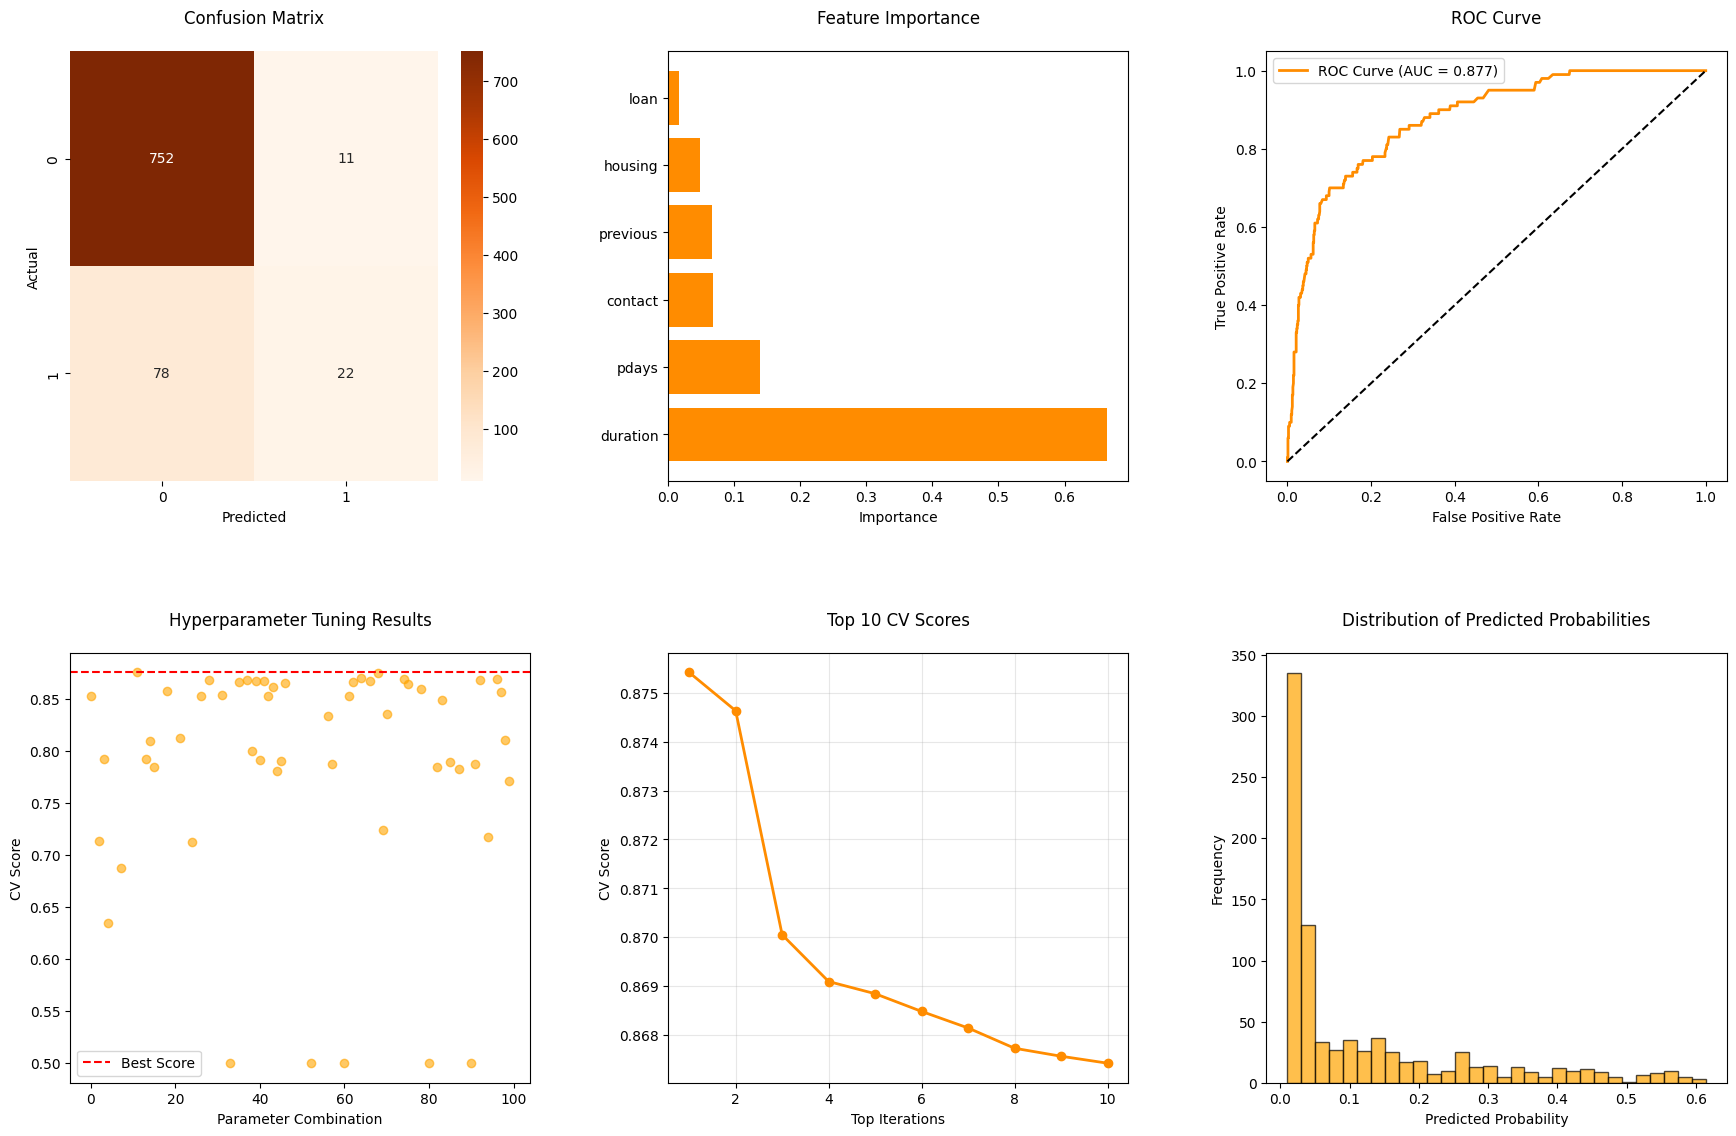


Cross-validation scores with best model:
CV Scores: [0.86754098 0.88943648 0.86599385 0.8673065  0.88682299]
Mean CV Score: 0.8754 (+/- 0.0208)

Random Forest Specific Analysis:
Number of trees: 500
Max depth: 30
Min samples split: 2
Min samples leaf: 1
Max features: 0.5
Average tree depth: 7.48
Tree depth range: 5 - 12

Saving the model...
Model saved as 'best_random_forest_model.pkl'
Label encoders saved as 'rf_label_encoders.pkl'

FINAL SUMMARY
Best Model: Random Forest with automated hyperparameter tuning
Features used: 6 features
Training samples: 3448
Test samples: 863
Best CV Score: 0.8754
Test Accuracy: 0.8969
Test ROC-AUC: 0.8775
Most important feature: duration
Out-of-bag Score: 0.8950

Random Forest Complexity Analysis:
Average nodes per tree: 39
Node count range: 39 - 39

Feature usage across trees:
    feature  usage_count  usage_percentage
0  duration        500.0             100.0
5     pdays        496.0              99.2
1   contact        491.0              98.2
2   

In [4]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Loading data...")
df = pd.read_csv('bank_cleaned.csv')
print(f"Dataset shape: {df.shape}")

selected_features = ['duration', 'contact', 'housing', 'loan', 'previous', 'pdays']
target = 'y'

print(f"\nSelected features: {selected_features}")
print(f"Target variable: {target}")

missing_features = [col for col in selected_features + [target] if col not in df.columns]
if missing_features:
    print(f"Missing columns: {missing_features}")
    print(f"Available columns: {list(df.columns)}")
    exit()

print("\nPreprocessing data...")

X = df[selected_features].copy()
y = df[target].copy()

print("Feature info:")
print(X.info())
print(f"\nTarget distribution:")
print(y.value_counts())

categorical_features = []
numerical_features = []

for col in selected_features:
    if X[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {le.classes_}")

if y.dtype == 'object':
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(y)
    print(f"Target encoded: {target_encoder.classes_}")

print("\nSplitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution:\n{pd.Series(y_train).value_counts()}")

print("\nSetting up hyperparameter tuning...")

param_distributions = {
    'n_estimators': [100, 200, 300, 500, 800, 1000],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 10],
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.05, 0.1],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1, 
    oob_score=True 
)

print("Starting hyperparameter tuning...")
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=100,  
    cv=5,        
    scoring='roc_auc',
    n_jobs=-1,   
    random_state=42,
    verbose=1
)

print("Training model with hyperparameter tuning (this may take a while)...")
random_search.fit(X_train, y_train)

print("\nBest hyperparameters found:")
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_

if hasattr(best_model, 'oob_score_'):
    print(f"Out-of-bag score: {best_model.oob_score_:.4f}")

print("\nEvaluating model performance...")

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nFeature Importance:")
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix', fontsize=12, pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 3, 2)
plt.barh(feature_importance['feature'], feature_importance['importance'], color='darkorange')
plt.title('Feature Importance', fontsize=12, pad=20)
plt.xlabel('Importance')

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.subplot(2, 3, 3)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=12, pad=20)
plt.legend()

plt.subplot(2, 3, 4)
cv_results = pd.DataFrame(random_search.cv_results_)
plt.scatter(range(len(cv_results)), cv_results['mean_test_score'], alpha=0.6, color='orange')
plt.xlabel('Parameter Combination')
plt.ylabel('CV Score')
plt.title('Hyperparameter Tuning Results', fontsize=12, pad=20)
plt.axhline(y=random_search.best_score_, color='red', linestyle='--', label='Best Score')
plt.legend()

plt.subplot(2, 3, 5)
top_scores = cv_results.nlargest(10, 'mean_test_score')['mean_test_score'].values
plt.plot(range(1, 11), top_scores, 'o-', color='darkorange', linewidth=2, markersize=6)
plt.xlabel('Top Iterations')
plt.ylabel('CV Score')
plt.title('Top 10 CV Scores', fontsize=12, pad=20)
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
plt.hist(y_pred_proba, bins=30, alpha=0.7, edgecolor='black', color='orange')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities', fontsize=12, pad=20)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

print("\nCross-validation scores with best model:")
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\nRandom Forest Specific Analysis:")
print(f"Number of trees: {best_model.n_estimators}")
print(f"Max depth: {best_model.max_depth}")
print(f"Min samples split: {best_model.min_samples_split}")
print(f"Min samples leaf: {best_model.min_samples_leaf}")
print(f"Max features: {best_model.max_features}")

tree_depths = [tree.tree_.max_depth for tree in best_model.estimators_]
print(f"Average tree depth: {np.mean(tree_depths):.2f}")
print(f"Tree depth range: {min(tree_depths)} - {max(tree_depths)}")

print("\nSaving the model...")
import joblib
joblib.dump(best_model, 'best_random_forest_model.pkl')
joblib.dump(label_encoders, 'rf_label_encoders.pkl')
print("Model saved as 'best_random_forest_model.pkl'")
print("Label encoders saved as 'rf_label_encoders.pkl'")

print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)
print(f"Best Model: Random Forest with automated hyperparameter tuning")
print(f"Features used: {len(selected_features)} features")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Best CV Score: {random_search.best_score_:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"Most important feature: {feature_importance.iloc[0]['feature']}")
if hasattr(best_model, 'oob_score_'):
    print(f"Out-of-bag Score: {best_model.oob_score_:.4f}")
print("="*50)

def predict_new_data(model, encoders, new_data_dict):
   
    new_df = pd.DataFrame([new_data_dict])
    
    for col in encoders.keys():
        if col in new_df.columns:
            new_df[col] = encoders[col].transform(new_df[col])
    
    prediction = model.predict(new_df)[0]
    probability = model.predict_proba(new_df)[0]
    
    return prediction, probability

def analyze_forest_complexity(model):
    """Analyze the complexity of the Random Forest model"""
    print("\nRandom Forest Complexity Analysis:")
    
    n_nodes = [tree.tree_.node_count for tree in model.estimators_]
    print(f"Average nodes per tree: {np.mean(n_nodes):.0f}")
    print(f"Node count range: {min(n_nodes)} - {max(n_nodes)}")
    
    feature_usage = np.zeros(len(selected_features))
    for tree in model.estimators_:
        features_used = np.unique(tree.tree_.feature[tree.tree_.feature >= 0])
        for feature_idx in features_used:
            feature_usage[feature_idx] += 1
    
    feature_usage_df = pd.DataFrame({
        'feature': selected_features,
        'usage_count': feature_usage,
        'usage_percentage': (feature_usage / len(model.estimators_)) * 100
    }).sort_values('usage_percentage', ascending=False)
    
    print("\nFeature usage across trees:")
    print(feature_usage_df)
    
    return feature_usage_df

feature_usage_analysis = analyze_forest_complexity(best_model)

print("\nExample prediction function created!")
print("Use predict_new_data(best_model, label_encoders, your_data) to predict new samples")
print("\n" + "="*60)
print("RANDOM FOREST MODEL ADVANTAGES:")
print("="*60)
print("✓ Robust to overfitting with many trees")
print("✓ Handles missing values naturally")
print("✓ Provides feature importance without additional computation")
print("✓ Works well with both numerical and categorical features")
print("✓ Out-of-bag error estimation (built-in validation)")
print("✓ Less sensitive to hyperparameters than other algorithms")
print("✓ Parallel training capability")
print("="*60)